# Bank Customer Segmentation

In this kernel I will perform segmentation of German bank customers. The first step is to read necessary libraries. We will use: 
* [pandas](https://pandas.pydata.org/) - to manipulate data frames
* [numpy](http://www.numpy.org/) - providing linear algebra
* [seaborm](https://seaborn.pydata.org/) - to create nice visualizations
* [matplotlib](https://matplotlib.org/) - basic tools for visualizations
* [scikit-learn](https://scikit-learn.org/stable/) - machine learning library

From sklearn, I will import necessary pre-processing tools and two clustering algorithms: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html).


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Reading the raw data 

In [38]:
data = pd.read_csv("german_credit_data.csv")

A visual control of the first five rows.

In [80]:
data.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

It looks that the first column is simply an index which we can delete. I will check how many missing values are in each column and of what data types they are. 

In [41]:
job_mapping = {
    0: 'unskilled and non-resident',
    1: 'unskilled and resident',
    2: 'skilled',
    3: 'highly skilled'
}
data['Job'] = data['Job'].replace(job_mapping)

In [42]:
data.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,skilled,own,NaN,little,1169,6,radio/TV
1,1,22,female,skilled,own,little,moderate,5951,48,radio/TV
2,2,49,male,unskilled and resident,own,little,NaN,2096,12,education
3,3,45,male,skilled,free,little,little,7882,42,furniture/equipment
4,4,53,male,skilled,free,little,little,4870,24,car
5,5,35,male,unskilled and resident,free,NaN,NaN,9055,36,education
6,6,53,male,skilled,own,quite rich,NaN,2835,24,furniture/equipment
7,7,35,male,highly skilled,rent,little,moderate,6948,36,car
8,8,61,male,unskilled and resident,own,rich,NaN,3059,12,radio/TV
9,9,28,male,highly skilled,own,little,moderate,5234,30,car


In [43]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} observations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print()
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print()
print("Columns data types:\n{}".format(data.dtypes))
print()

Database has 1000 observations (customers) and 9 columns (attributes).

Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Columns data types:
Age                  int64
Sex                 object
Job                 object
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object



Out of 9 columns 2 contain missing values. Probably these are customers who don’t have one of these two accounts. 

Generally, there are 3 numeric variables and 6 categorical ones.

Now, I will check how many, and what are the possible (unique) values in each categorical column.

In [45]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [46]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Job : ['skilled' 'unskilled and resident' 'highly skilled'
 'unskilled and non-resident']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Exploratory Data Analysis**


Below I will generate plots for all variables to knoow the frequency distribution 

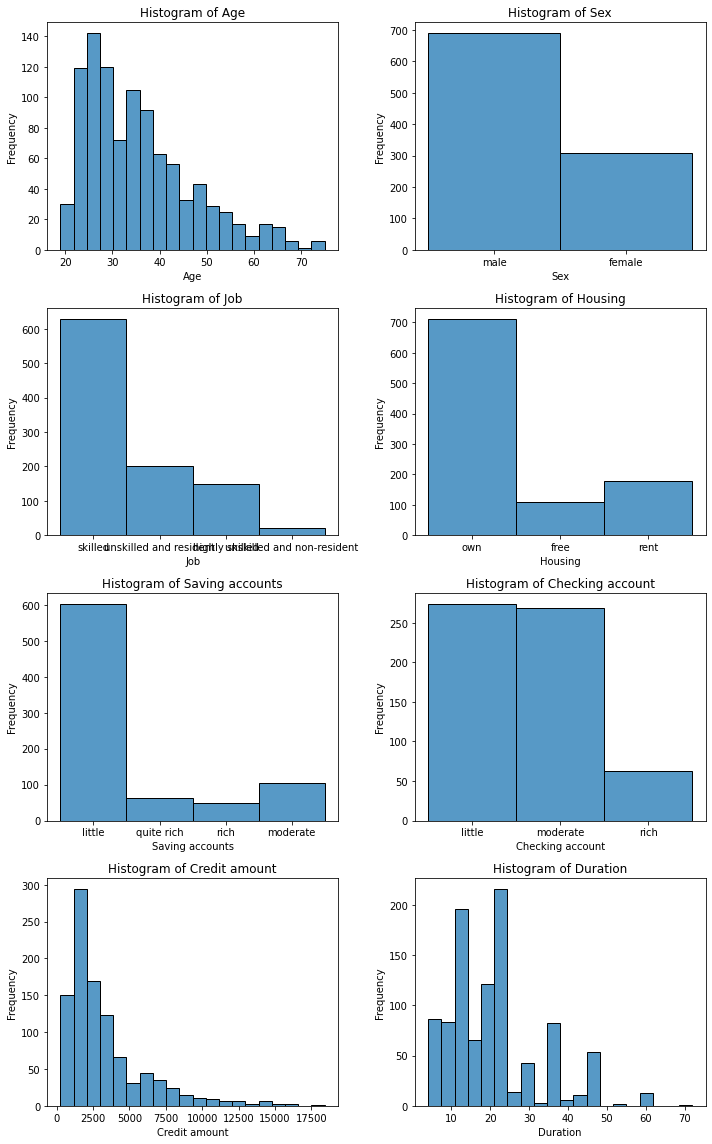

In [101]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming you have it loaded as 'data')

# List of columns for which you want to plot histograms
columns_to_plot =data.columns.tolist() 
columns_to_plot.remove('Purpose')
# Calculate the number of rows and columns for the subplot grid
num_rows = (len(columns_to_plot) + 1) // 2  # Add 1 to handle odd number of columns
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))

# Flatten the axes array if num_rows > 1
axes = axes.flatten()

# Loop through the columns and plot histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data[column], bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

Below I will define a function which will generate plots for three numeric variables with stratification by selected categorical column.

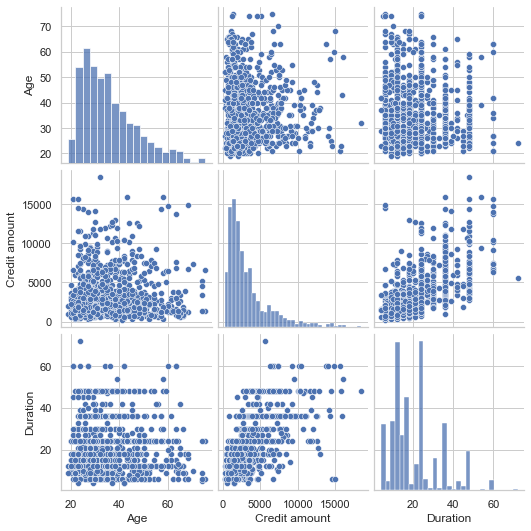

In [118]:

numerical_columns = ['Age', 'Credit amount', 'Duration']
categorical_columns = ['Sex', 'Housing', 'Purpose']

# Set style
sns.set(style='whitegrid')

# Scatter Plots
sns.pairplot(data[numerical_columns])
plt.show()


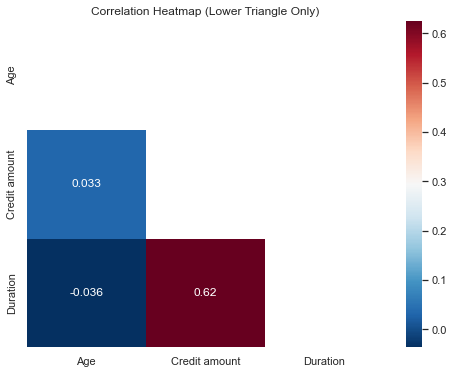

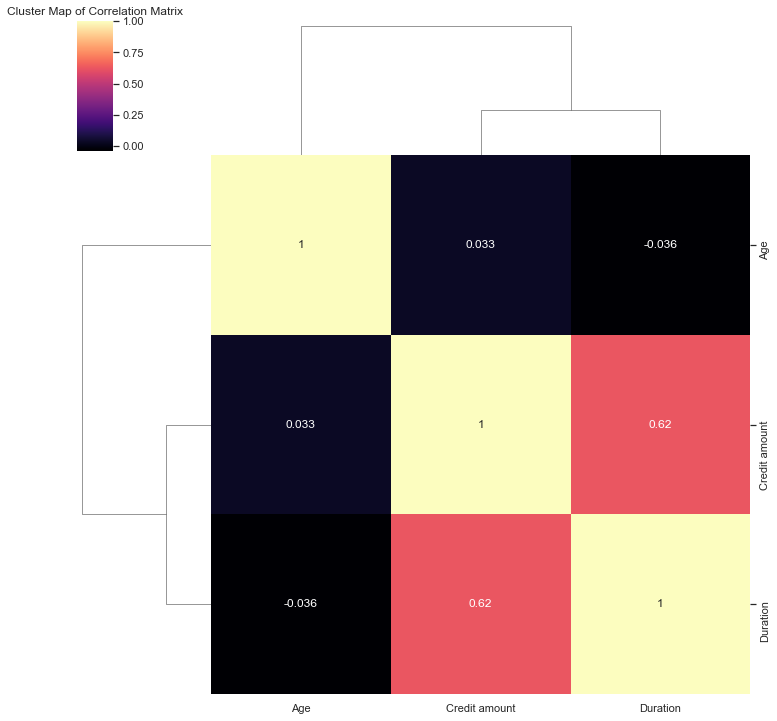

In [119]:
# Heatmap of Correlation Matrix
# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', mask=mask)
plt.title('Correlation Heatmap (Lower Triangle Only)')
plt.show()

# Cluster Map
sns.clustermap(data[numerical_columns].corr(), annot=True, cmap='magma')
plt.title('Cluster Map of Correlation Matrix')
plt.show()

We can see from the correlation matrix that Age and Credit Amount have almost 0 correlation. So, Credit amount is almost
independent of the Age . But there is a good relationship between Credit Amount and Duration . With increasing amount duration 
also increases


<Figure size 576x432 with 0 Axes>

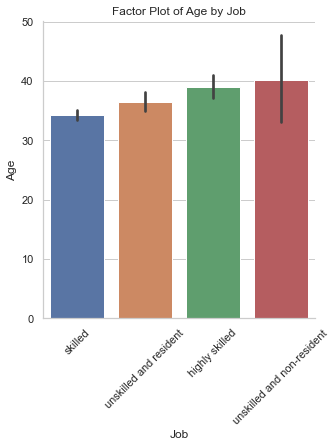

<Figure size 576x432 with 0 Axes>

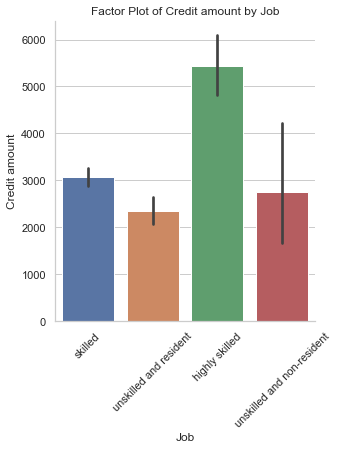

<Figure size 576x432 with 0 Axes>

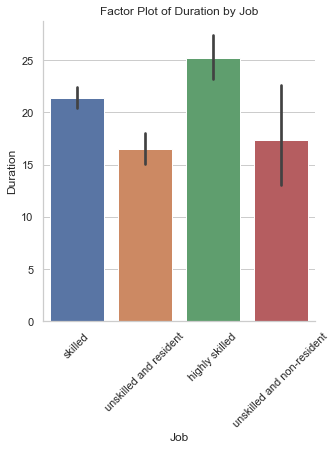

In [120]:
# Factor Plots
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.catplot(x='Job', y=col, data=data, kind='bar')
    plt.title(f'Factor Plot of {col} by Job')
    plt.xticks(rotation=45)
    plt.show()

From here we can see the dominance effect of Highly skilled person 

In [121]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,12))
    x1 = sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    x1.set_xlabel('Credit Amount ', fontdict={'size': 10})
    x1.set_ylabel('Duration (Months)', fontdict={'size': 10})
    
    x2 = sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    x2.set_xlabel('Age ', fontdict={'size': 10})
    x2.set_ylabel('Credit Amount', fontdict={'size': 10})
    
    x3 = sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    x3.set_xlabel('Age ', fontdict={'size': 10})
    x3.set_ylabel('Duration(Months)', fontdict={'size': 10})

At the beginning let’s look at scatter plots our 3 numerical variables stratified by sex.

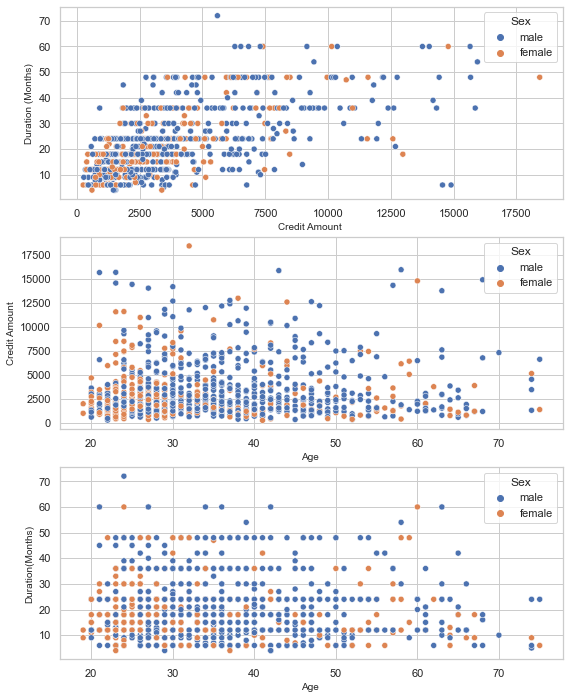

In [122]:
scatters(data, h="Sex")

The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some positive correlation between duration and amount of credit, what makes sense. 

Let’s check the linear correlation between credit amount and duration

pearsonr : 0.6249841983009835
p : 1.8628512880465833e-109


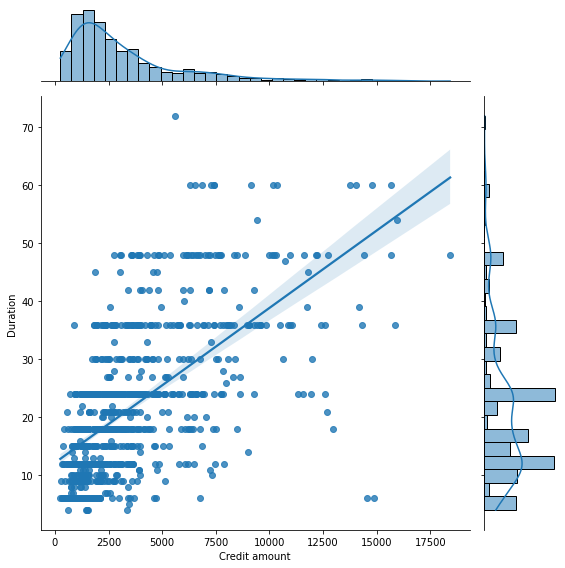

In [98]:

import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount", y="Duration", data=data, kind="reg", height=8)
pearson_corr, _ = stats.pearsonr(data["Credit amount"], data["Duration"])

print('pearsonr :',pearson_corr)
print('p :',_)
plt.show()



The pearson_corr value and _ value obtained using stats.pearsonr represent the Pearson correlation coefficient and a corresponding p-value. Let me explain each of these concepts with an example:

Pearson Correlation Coefficient:
The Pearson correlation coefficient is a statistical measure that quantifies the strength and direction of a linear relationship between two continuous variables. It ranges between -1 and 1, where:

A value close to 1 indicates a strong positive linear relationship (as one variable increases, the other tends to increase).
A value close to -1 indicates a strong negative linear relationship (as one variable increases, the other tends to decrease).
A value close to 0 indicates a weak or no linear relationship between the variables.
For example, consider a dataset of students where you have their study hours and exam scores. If there is a positive correlation between study hours and exam scores, a high Pearson correlation coefficient would indicate that students who study more tend to have higher exam scores.

P-value:
The p-value is a measure of the evidence against a null hypothesis. In the context of the Pearson correlation coefficient, the null hypothesis assumes that there is no correlation between the two variables. The p-value helps you determine whether the observed correlation coefficient is statistically significant or could have occurred by random chance.

Typically, a smaller p-value (usually less than 0.05) suggests that the correlation is statistically significant and provides evidence against the null hypothesis. A larger p-value indicates that the correlation could have occurred by chance, and you wouldn't have strong evidence to reject the null hypothesis.

For example, if you find a high Pearson correlation coefficient between study hours and exam scores with a very low p-value, it suggests that the correlation is likely not due to random chance and is significant

The plot above shows a linear correlation with Pearson value of 0.62 and very small p-value. That make’s sense because usually, people take bigger credits for longer periods.  Below I will analyse linear regression plots with various categorisations.

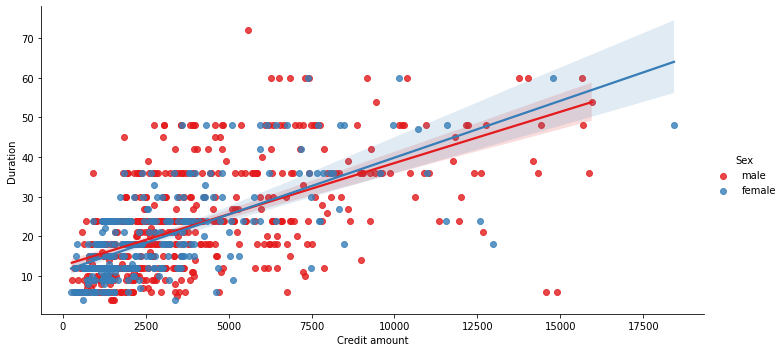

In [11]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

The plot above indicates that there is no significant difference between men and women.

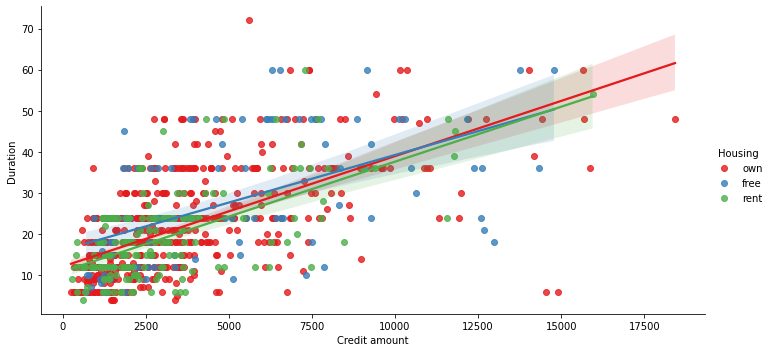

In [12]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

The plot above shows similarly that there is no diference betwen housing categories.

Below I will show “business” area where granted the biggest amount of credits. 

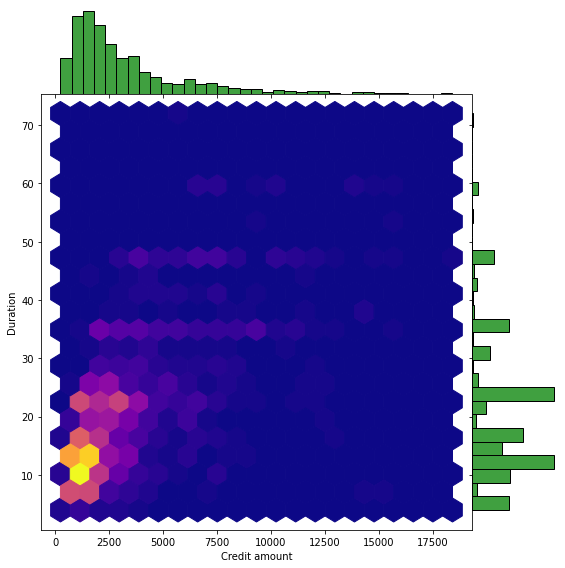

In [60]:
sns.jointplot(x="Credit amount", y="Duration", data=data,kind="hex",height=8, joint_kws={'gridsize': 20, 'cmap': 'plasma'} ,space=0, color="g")
plt.show()


In [61]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

n_credits

,Purpose,Count
1,car,337
5,radio/TV,280
4,furniture/equipment,181
0,business,97
3,education,59
6,repairs,22
2,domestic appliances,12
7,vacation/others,12


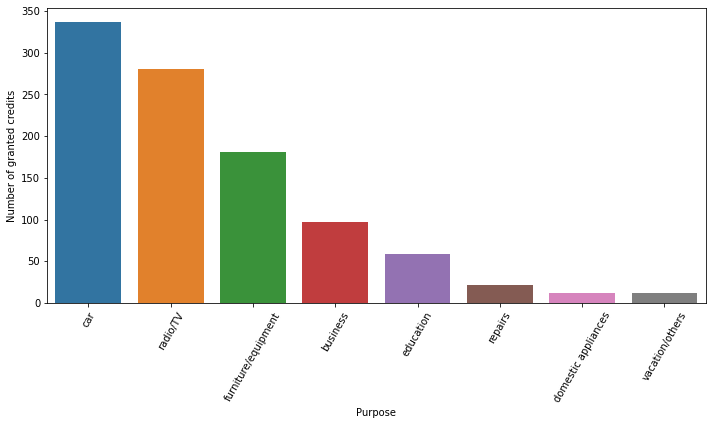

In [62]:
plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

The barplot above shows how many credits were granted for various purposes. Most of credits were granted for car and radio/TV.

Now I will generate boxplots for detailed analysis of categorical variables.

In [64]:
def boxes(x,y,h):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels())
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()

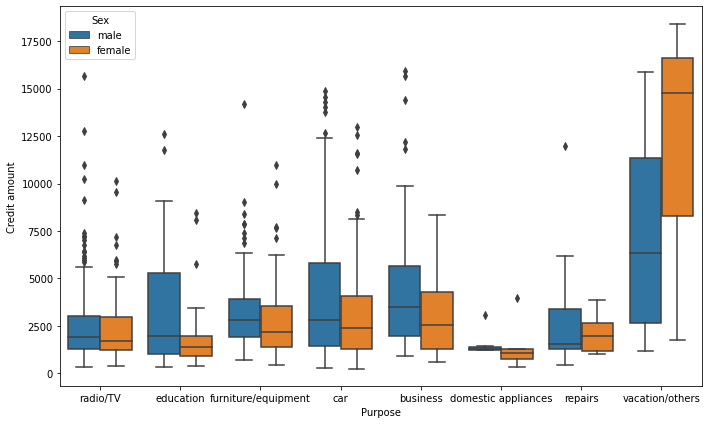

In [65]:
boxes("Purpose","Credit amount","Sex")

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category. 

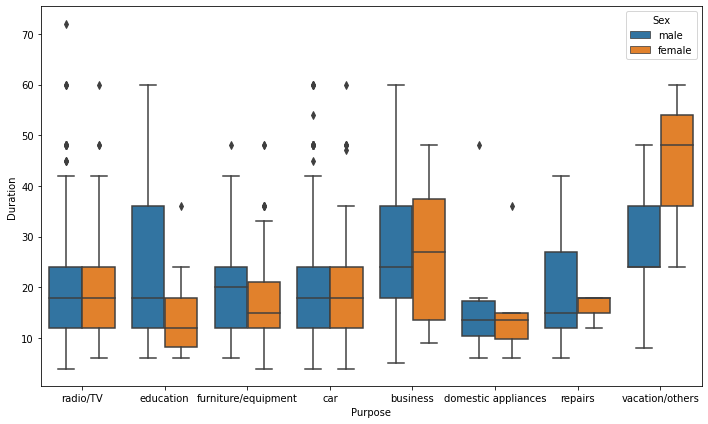

In [66]:
boxes("Purpose","Duration","Sex")

The boxplot above indicates that generally there is no difference in credit duration between men and women. We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances.  It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

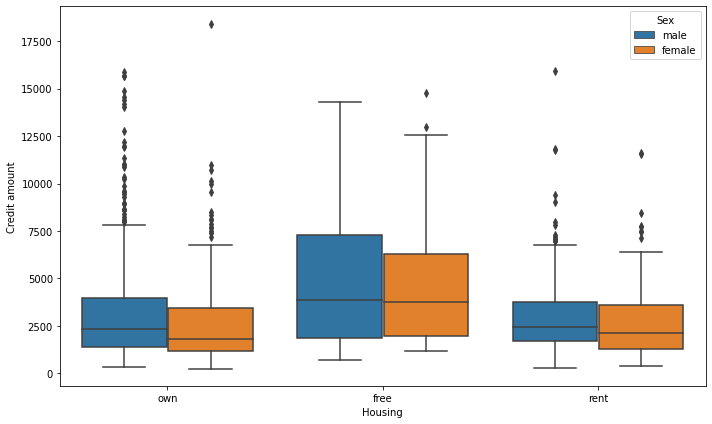

In [67]:
boxes("Housing","Credit amount","Sex")

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

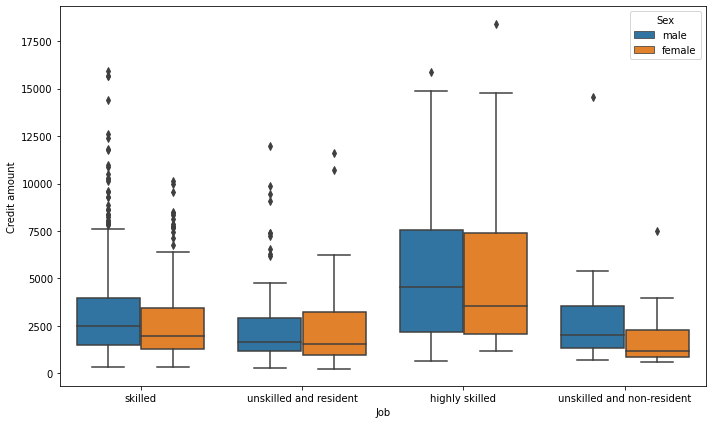

In [68]:
boxes("Job","Credit amount","Sex")

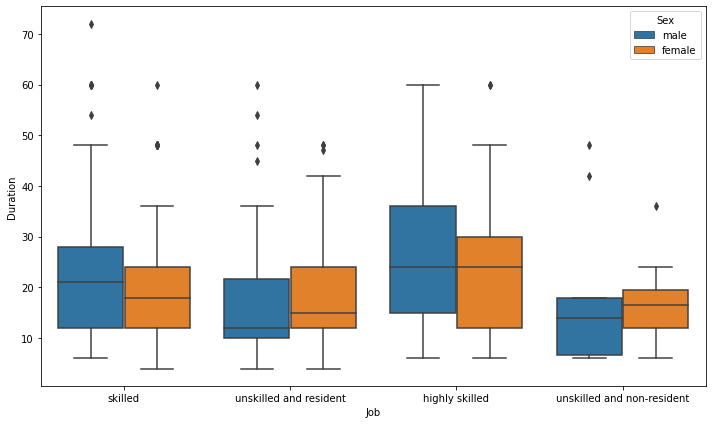

In [69]:
boxes("Job","Duration","Sex")

In terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer duration.  

And at the end if someone likes 3D plots here you go.

Text(0.5, 0, 'Age')

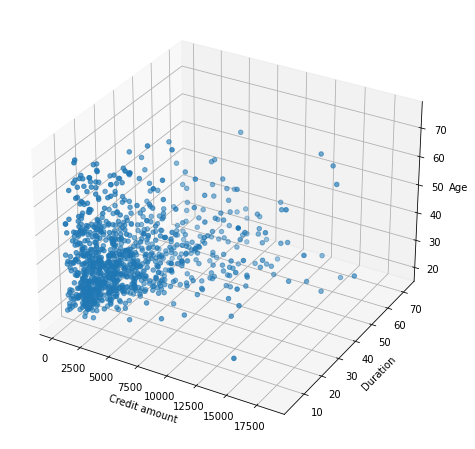

In [70]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

**Clustering with KMeans**

For clustering, I will create a subset containing only numerical variables (Age, Credit amount, Duration). 

In [23]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]
cluster_data.head()

,Age,Credit amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24


I will create a function which plots three histograms - one for each variable. 

In [24]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Let's look at the histograms.

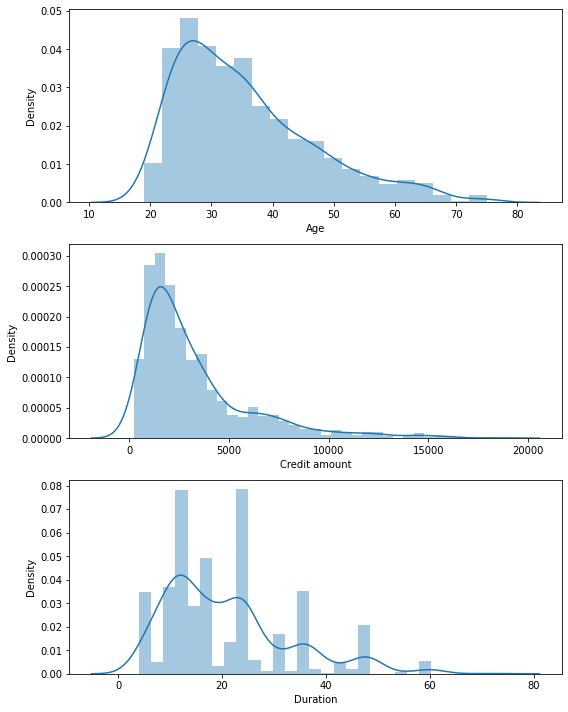

In [25]:
distributions(cluster_data)

We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation. After that let's see how they look like.

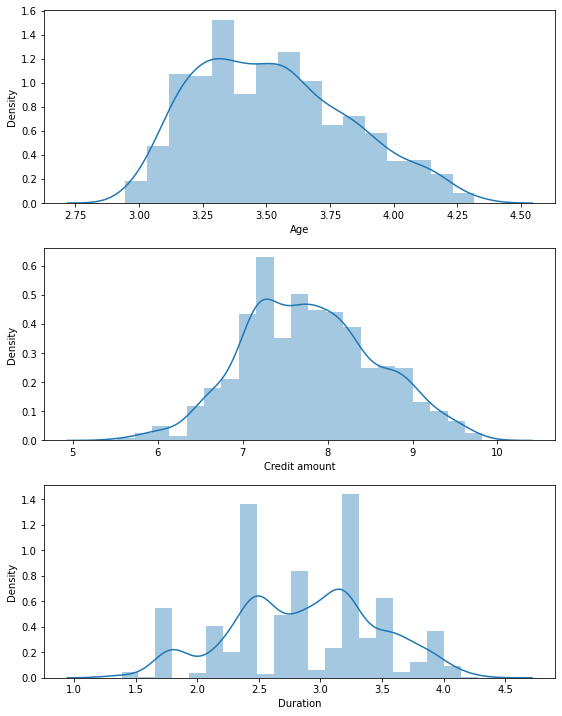

In [71]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Indeed, the skewness has been eliminated. 

The next step will be centering and scaling of variables – it is required by KMeans algorithm.  We will use for that a StandardScaler from sklearn library. 

In [72]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

I will check how inertia changes for various number of clusters.

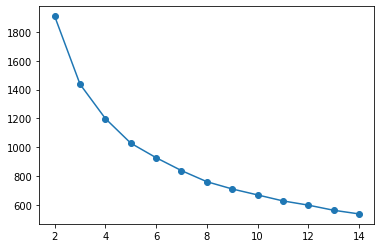

In [73]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

The plot above shows that inertia decreases with increasing number of clusters. 

This method allows for assessment of cluster separations and fitting of each observation in its own cluster.  The highest score the better.  I will perform this analysis for various seeds as well.

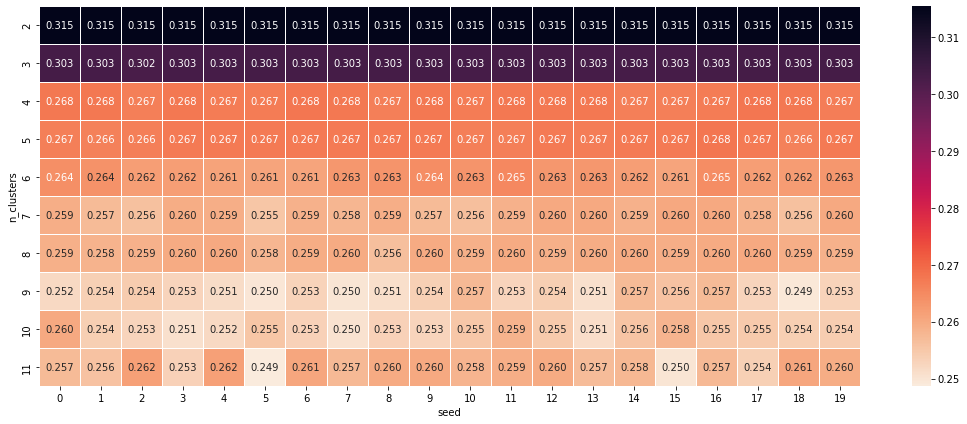

In [74]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,12)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed. 

I will chose 3 clusters to get more insight into data.

In [75]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Below I will create silhouette graph for 3 clusters in order to visually depict fit of each point within its own cluster (modified code from scikit-learn doc).

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.302902483090709


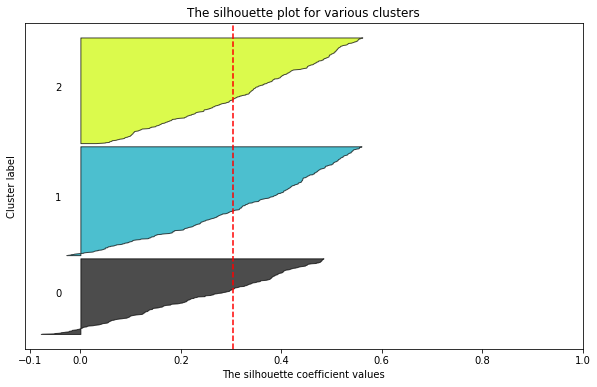

In [76]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

I will define a function showing clusters on the scatter plot.  

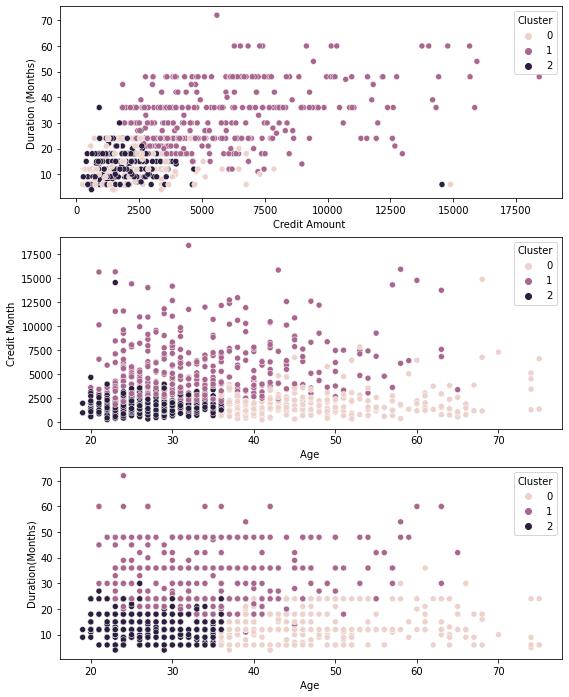

In [77]:
scatters(clustered_data, 'Cluster')

Plots above show three created clusters. Two bottom ones show relatively clear separation of clusters, but it is no so evident on the top one. 

I will generate now a heatmap plot for easier business interpretation of customer segmentation.  

In [78]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,Age,Credit amount,Duration
Cluster,,,
0,48.6,1970.5,13.9
1,34.0,5665.4,32.2
2,27.7,1737.5,14.3


Cluster 0 –  lower mean of credit amount, short duration, older customers

Cluster 1 – high mean of credit amount, long duration, middle-aged customers

Cluster 2 - lower mean of credit amount, short duration, young customers

**Clustering with Affinity Propagation**

In this algorithm there are two relevant parameters: preference and dumping. It means that we don’t define upfront number of clusters, algorithm itself chooses their number. I will fix dumping and check number of clusters in function of preference parameter.  

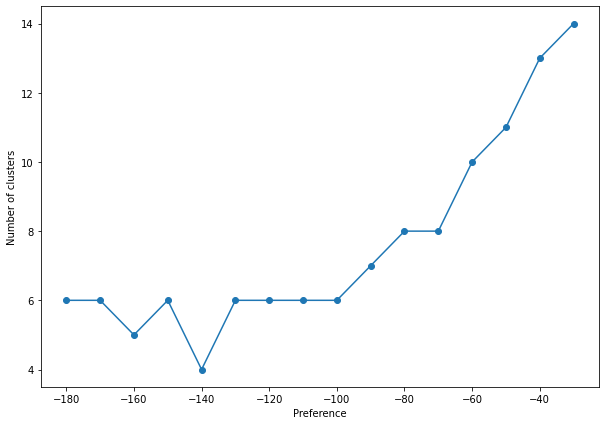

In [79]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')


Together with decreasing value of preference parameter number of clusters goes down as well and levels for very small preference values. I will check four clusters option. 

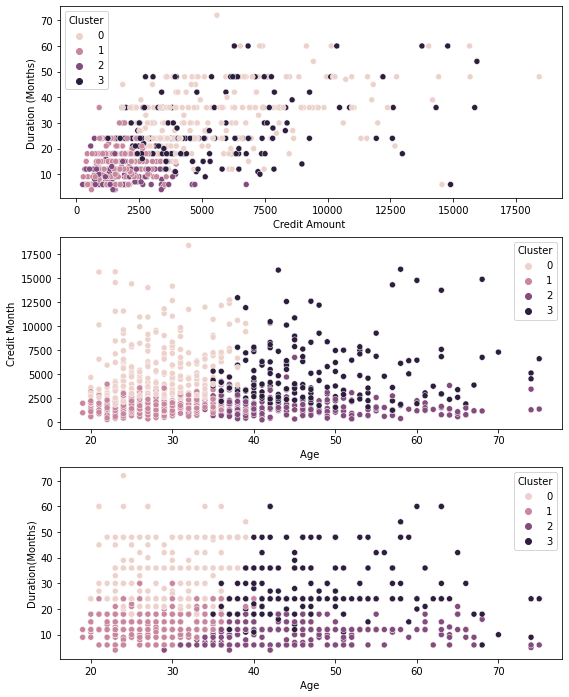

In [35]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)


In [36]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)
grouped_af

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


Cluster 0 – high mean of credit amount, long duration, younger customers

Cluster 1 – low mean of credit amount, short duration, younger customers

Cluster 2 - low mean of credit amount, short duration, older customers

Cluster 3 - high mean of credit amount, middle-time duration, older customers